# Regularized RegVelo-based analysis of hematopoiesis dataset

Notebook runs the regularized regvelo model on the hematopoiesis dataset.

## Library imports

In [ ]:
import numpy as np
import pandas as pd
import torch

import matplotlib.pyplot as plt
import mplscience

import anndata as ad
import cellrank as cr
import scanpy as sc
import scvi
from regvelo import REGVELOVI

from rgv_tools import DATA_DIR, FIG_DIR
from rgv_tools.benchmarking import set_output

/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packag

## General settings

In [2]:
scvi.settings.seed = 0

[rank: 0] Seed set to 0


## Constants

In [3]:
DATASET = "hematopoiesis"

In [ ]:
SAVE_DATA = True
if SAVE_DATA:
    (DATA_DIR / DATASET / "results").mkdir(parents=True, exist_ok=True)

In [ ]:
SAVE_FIGURES = True
if SAVE_FIGURES:
    (FIG_DIR / DATASET).mkdir(parents=True, exist_ok=True)

In [ ]:
## four terminal states consistently recovered by all three methods
TERMINAL_STATES = ["Mon", "Meg", "Bas", "Ery"]

## Data loading

In [ ]:
adata = ad.io.read_h5ad(DATA_DIR / DATASET / "processed" / "adata_preprocessed.h5ad")
adata_full = ad.io.read_h5ad(DATA_DIR / DATASET / "processed" / "adata_preprocessed_full.h5ad")

## Run RegVelo

In [ ]:
## prepare skeleton
skeleton = adata.uns["skeleton"].copy()
skeleton = torch.tensor(np.array(skeleton)).int()

## prepare TF
tfs = adata.var_names[adata.var["tf"]]

## prepare model
REGVELOVI.setup_anndata(adata, spliced_layer="Ms", unspliced_layer="Mu")
vae = REGVELOVI(adata, W=skeleton.T, regulators=tfs, lam2=1)

In [8]:
vae.train()

/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/dynamo/lib/pyth ...
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/dynamo/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on yo

Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -324.148. Signaling Trainer to stop.


In [9]:
set_output(adata, vae, n_samples=30, batch_size=adata.n_obs)

## Evaluate uncertainty

In [10]:
uncertainty_df, _ = vae.get_directional_uncertainty(n_samples=50)

INFO     regvelo: Sampling from model...                                                                           
INFO     regvelo: Computing the uncertainties...                                                                   


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)


In [11]:
adata.obs["RegVelo intrinsic uncertainty"] = np.log10(uncertainty_df["directional_cosine_sim_variance"].values + 1e-6)

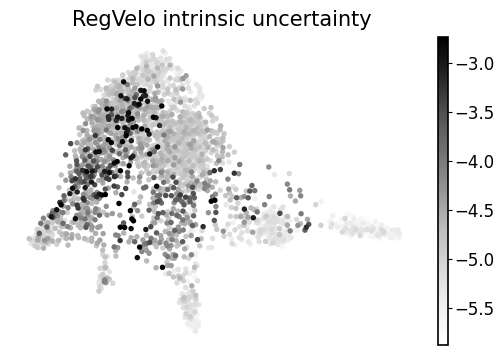

In [12]:
with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(6, 4))
    sc.pl.embedding(
        adata,
        color="RegVelo intrinsic uncertainty",
        cmap="Greys",
        basis="draw_graph_fa",
        vmin="p1",
        vmax="p99",
        ax=ax,
        frameon=False,
    )

if SAVE_FIGURES:
    fig.savefig(FIG_DIR / DATASET / "rgv_uncertainty.svg", format="svg", transparent=True, bbox_inches="tight")

In [13]:
uncertainty = pd.DataFrame({"uncertainty": uncertainty_df["directional_cosine_sim_variance"].values})

## Calculate lineage fate probabilities and identify fate-associated genes

In [ ]:
vk = cr.kernels.VelocityKernel(adata)
vk.compute_transition_matrix()
estimator = cr.estimators.GPCCA(vk)  ## We used vk here due to we want to benchmark on velocity
estimator.compute_macrostates(n_states=5, cluster_key="cell_type")

estimator.set_terminal_states(TERMINAL_STATES)
estimator.compute_fate_probabilities()

estimator.adata = adata_full.copy()
rgv_ranking = estimator.compute_lineage_drivers(return_drivers=True, cluster_key="cell_type")

rgv_ranking = rgv_ranking.loc[:, ["Ery_corr", "Mon_corr", "Ery_pval", "Mon_pval"]]

  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Defaulting to `'gmres'` solver.


  0%|          | 0/4 [00:00<?, ?/s]

ERROR: Unable to duplicate function call using shadow `anndata.AnnData` object. Reason: `value.index does not match parent’s var names:
Index are different

Index length are different
[left]:  2000, Index(['DPM1', 'GCLC', 'NFYA', 'ANKIB1', 'LASP1', 'ALS2', 'CFLAR', 'AK2',
       'RBM6', 'SLC25A13',
       ...
       'HERC2P2', 'STAG3L2', 'PMS2P14', 'PSMB3', 'DDX52', 'MYO19', 'PMS2P2',
       'ACACA', 'MRPL45', 'WASH9P'],
      dtype='object', length=2000)
[right]: 159, Index(['ADCY6', 'ALS2', 'ANKRD36C', 'ANXA1', 'ARHGAP11A', 'ARHGAP30', 'ARID5B',
       'ASPM', 'ATF6', 'BACE2',
       ...
       'UFL1', 'VASH1', 'VIM', 'VWF', 'ZEB1', 'ZFHX3', 'ZFPM1', 'ZNF263',
       'ZNF274', 'ZYX'],
      dtype='object', length=159)`


## Save dataset

Recalculate the PCA for downstream CBC calculation because velocity is calculated from the moment matrices

In [15]:
sc.tl.pca(adata, layer="Ms")

Save adata with velocity layer

In [16]:
if SAVE_DATA:
    adata.write_h5ad(DATA_DIR / DATASET / "processed" / "adata_run_regvelo.h5ad")

Save uncertainty and gene ranking results

In [17]:
if SAVE_DATA:
    uncertainty.to_csv(DATA_DIR / DATASET / "results" / "uncertainty_rgv.csv")
    rgv_ranking.to_csv(DATA_DIR / DATASET / "results" / "rgv_ranking.csv")

Save the model

In [19]:
if SAVE_DATA:
    path = DATA_DIR / DATASET / "processed" / "rgv_model"
    vae.save(path)